**Description:** Exploratory Data Analysis on relevant features and spam and opt-out

**Author:** Elena (Chaoran) Gou

**Last Update:** 08/04/2021

In [ ]:
import pandas as pd
import numpy as np

import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

np.random.seed(2000)

In [ ]:
### Twilio brand colors: https://www.twilio.com/brand/resources/colorresources

# Primary Twilio brand colors
tw_red = '#F22F46'
night = '#001489'

# Secondary Twilio brand colors
blue = '#008CFF' # blue_50
green = '#36D576' # green_50
tangerine = '#F47C22'
yellow = '#FFDD35' #yellow_40
purple = '#8C5BD8' #purple_50

# extended pallete
gray_30 = '#CACDD8'
red_30 = '#f6b1b1'
orange_30 = '#FAC2A0'
green_30 = '#A2F6C3'
blue_30 = '#99CDFF'
purple_30 = '#C8AFF0'
gray_70 = '#4B5671'
red_70 = '#ad1111'
orange_70 = '#C35323'
green_70 = '#0E7C3A'
blue_70 = '#043CB5'
yellow_70 = '#C28E00'
purple_70 = '#5817BD'

teal = '#00BCD4'
mauve = '##DEA7E8'

charting_colors = [blue, green, tangerine, purple, yellow, tw_red, night,
                   gray_30, red_30, blue_30, orange_30, green_30, purple_30,
                   gray_70, red_70, blue_70, orange_70, green_70, purple_70]

#'#FF5722', '#FA9950', '#FAD100', '#4CB04F', '#36D576', '#303F9F', '#2196F3', '#00BCD4', '#00E5FF', '#7B1FA2', '#7C4DFF', '#880E4F', '#DEA7E8', '#FF4081', '#9E9E9E'


# Twilio fonts
fonts = ['Helvetica Neue', 'Helvetica', 'Arial', 'sans-serif']

# set colors and fonts
sns.set_style('ticks', {'axes.linewidth': 2., 'font.sans-serif': fonts, 'font.family': 'Helvetica Neue'})
plt.rc('figure', figsize=(16, 10))
sns.set_context('poster', font_scale=1.0)
sns.set_palette(charting_colors)

### Data Source
1. attempted_delivered_unwanted_xwalk.csv <br>
Count of 7726, opt-out, delivered sends, and attempted sends for each account in May 2021<br>
<br>
2. account_sid_ct_error_xwalk.csv <br>
Count of error code 30007, 30008, 21610, and unreachable (30003-30006, 21614) for each account in May 2021 <br>
<br>
3. account_aup_xwalk.csv <br>
Count of AUP for each account <br>
<br>
4. account_fraud_cannabis_xwalk.csv <br>
Count of Fraud and binary variable indicating if the account is related to cannabis or not <br>
<br>
5. sid_fam_size_xwalk.csv <br>
Family size for each account <br>
<br>
6. account_age_xwalk.csv <br>
Age for each account <br>
<br>
7. sid_first_twilio_xwalk.csv <br>
Indication of if an account is using the default name "My First Twilio Account"

### Read in Data

In [ ]:
account = pd.read_csv('attempted_delivered_unwanted_xwalk.csv')

In [ ]:
error = pd.read_csv('account_sid_ct_error_xwalk.csv')
error.head()

,account_sid,unreachable,_30007,_30008,_21610
0,AC00a1d4c68048d1c459fed91caa635370,5994,0,2413,27
1,ACaf440b677ae8f44df49a7a7457d8889a,10431,5,34,118
2,AC6c36e573045e93c8bc1187d82bf18454,2501,0,9,0
3,ACe94b13960d310da70f24f1362b5615be,400,0,6,128
4,AC16879d2e4d1606fdb3dadd94fa90b1aa,512,1589,16,0


### Merge different datasets

In [ ]:
account = account.merge(error, on='account_sid', how='left')

In [ ]:
#Account sid and AUP volume
aup = pd.read_csv('account_aup_xwalk.csv')
account = account.merge(aup, on='account_sid', how='left')
aup.head()

,account_sid,aup
0,AC4ecf38e966b466a50b1ff79e0c49e9f6,2
1,AC915680e3165261ff798cb8ff91bc53d7,2
2,ACff33ae990f5e2d3d4f03cb1f2f55c434,1
3,AC4b811192b90ec097bff1eb64709af441,5
4,AC5572a85c0340c786f88613f0a347b67d,420


In [ ]:
#Account sid, Fraud volume, and cannabis
fraud = pd.read_csv('account_fraud_cannabis_xwalk.csv')
account = account.merge(fraud, on='account_sid', how='left')
fraud.head()

,account_sid,cannabis,fraud
0,AC4ea6ce488425bec5b0511345b291b034,0,2643
1,ACe46b622eab80606a32538165bb927d88,0,19
2,ACedf1f6ce6a22a1ae391d5a1f18cffe69,0,1
3,AC845fff9e208ac4019a0bd7bcdadfa8b7,0,11
4,AC21ab049e9b869715c9db6a5ad5ef3400,0,1


In [ ]:
#Account sid and Family Size
fam_size = pd.read_csv('sid_fam_size_xwalk.csv')
fam_size.drop_duplicates(inplace=True)
fam_size.rename(columns={"sid": "account_sid"},inplace=True)
account = account.merge(fam_size, on='account_sid', how='inner')
fam_size.head()

,account_sid,fam_size
0,ACbff9fda438249703b2aa466635a1bec4,228
1,ACfd5612aae742d4d4f3bd193850ab3397,13
2,AC0cbd96821971b8fa4e5a24dfec749f04,2902
3,ACe9a6bac150e9957225eaf4228e4aedfc,904
4,AC39231b0806de15e18d83e31ab13a496b,904


In [ ]:
fam_size.describe()

,fam_size
count,2.469779e+07
mean,3.429415e+05
std,6.374644e+05
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.542920e+05
max,2.063543e+06


In [ ]:
#Account sid and Age
age = pd.read_csv('account_age_xwalk.csv')
age.rename(columns={"sid": "account_sid"},inplace=True)
account = account.merge(age, on='account_sid', how='left')
age.head()

,account_sid,age,parent,isv
0,ACfa9bfe5fcc797bcbf3a9ebc9990c4f67,50,0,0
1,ACf0bb3f1c70bf5d5dab4dde2998d06fc8,50,0,0
2,AC6ff0aa2a22ac5d6d135a3385c588e389,50,0,0
3,AC8db780fd3e4360e4ebb558e4f367c581,50,0,0
4,AC609ce4317ac974f49259c3b9b76440a3,50,0,0


In [ ]:
#Account sid and default name indicator
first_twilio = pd.read_csv('sid_first_twilio_xwalk.csv')
first_twilio.drop_duplicates(inplace=True)
first_twilio.rename(columns={"sid": "account_sid"},inplace=True)
account = account.merge(first_twilio, on='account_sid', how='left')
first_twilio.head()

,account_sid,friendly_name,default_name
0,AC9e3c42a4fbad30e6d2ef40c05a0cf633,Test Account for guzewyn@duck2.club's Account,0.0
1,AC1c5084ebea864f07feb4d2355771665d,My New Phone Verification Project,0.0
2,AC668589d13cfff86ade509a4342f1907e,Test Account for Polyantseveg86@gmail.com's Ac...,0.0
3,ACec37f1177a6a91bd86a5c7c5a54c55d9,My New SMS Chatbot Project,0.0
4,AC7799cd30a3a779ba4aa8c3c17ef37cc5,Test Account for ac24790@yahoo.com.tw's Account,0.0


### Sanity Check

In [ ]:
account.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442546 entries, 0 to 442545
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   attempted      442546 non-null  int64  
 1   account_sid    442546 non-null  object 
 2   delivered      436881 non-null  float64
 3   optouts        87444 non-null   float64
 4   _7726          9319 non-null    float64
 5   unreachable    442546 non-null  int64  
 6   _30007         442546 non-null  int64  
 7   _30008         442546 non-null  int64  
 8   _21610         442546 non-null  int64  
 9   aup            299 non-null     float64
 10  cannabis       1515 non-null    float64
 11  fraud          1515 non-null    float64
 12  fam_size       442546 non-null  int64  
 13  age            442546 non-null  int64  
 14  parent         442546 non-null  int64  
 15  isv            442546 non-null  int64  
 16  friendly_name  442542 non-null  object 
 17  default_name   442546 non-nul

In [ ]:
account.head()

,attempted,account_sid,delivered,optouts,_7726,unreachable,_30007,_30008,_21610,aup,cannabis,fraud,fam_size,age,parent,isv,friendly_name,default_name
0,291830197,AC0c4da9c0a8c20ea8890c2ca186768bed,279827613.0,NaN,383.0,10232167,677429,671412,3538,NaN,NaN,NaN,27,68,1,1,us-east-1,0.0
1,770805,ACbdccf1d7b857189e72fdb51c878d34db,768406.0,NaN,NaN,1674,0,725,0,NaN,NaN,NaN,1,43,0,1,Samsung,0.0
2,92827,AC21e3df471603c934315eb61694a18ab2,90908.0,1.0,NaN,935,0,984,0,NaN,NaN,NaN,1,25,0,0,j.teichert@vivenu.com's Account,0.0
3,4682,AC4be872f5cb700cf41676089db563bbc9,4518.0,NaN,NaN,158,3,2,0,NaN,NaN,NaN,17523,34,1,0,Meevo M2NA0_ T10713-Tenant: 45206,0.0
4,25605,AC4cac4fec76a9decc2838641318025fa6,22138.0,327.0,3.0,3432,9,26,0,NaN,NaN,NaN,6294,19,1,0,k.morrisonhealthadvisor@gmail.com,0.0


### Data Preprocessing

In [ ]:
account = account.fillna(0)
#Add threshold to remove outliers
account = account[(account['attempted']>1000) & (account['delivered']>1)]

In [ ]:
#Generate percentages
account['optout_perc'] = account['optouts']/account['delivered']
account['_7726_perc'] = account['_7726']/account['delivered']
account['_30008_perc'] = account['_30008']/account['attempted']
account['_30007_perc'] = account['_30007']/account['attempted']
account['_21610_perc'] = account['_21610']/account['attempted']
account['unreachable_perc'] = account['unreachable']/account['attempted']
account['aup_perc'] = account['aup']/account['attempted']
account['fraud_perc'] = account['fraud']/account['attempted']

In [ ]:
#Make sure all percentages <=1
account = account[account['aup_perc']<=1] #drop 4 accounts
account = account[account['fraud_perc']<=1] #drop 1 account

### Explore the Correlation between Features and Unwanted Communications Rates

In [ ]:
account.corr()

,attempted,delivered,optouts,_7726,unreachable,_30007,_30008,_21610,aup,cannabis,...,parent,isv,optout_perc,_7726_perc,_30008_perc,_30007_perc,_21610_perc,unreachable_perc,aup_perc,fraud_perc
attempted,1.000000,0.998995,0.046721,0.154658,0.848313,0.216963,0.632501,0.033247,0.007196,0.001593,...,-0.018214,0.014603,-0.005368,-0.002144,-0.000813,-0.000355,0.005395,-0.002501,0.000866,0.000311
delivered,0.998995,1.000000,0.041119,0.152233,0.839257,0.207594,0.624760,0.020024,0.006852,0.001258,...,-0.017947,0.014412,-0.005642,-0.002281,-0.001170,-0.001389,0.001400,-0.003010,0.000743,0.000227
optouts,0.046721,0.041119,1.000000,0.585371,0.070251,0.191707,0.027356,0.217846,0.138985,0.015618,...,-0.020221,0.013417,0.130995,0.035853,0.004011,0.045796,0.054429,0.021089,0.025105,0.017608
_7726,0.154658,0.152233,0.585371,1.000000,0.156061,0.303248,0.059102,0.013043,0.259414,0.003903,...,-0.020364,0.018270,0.104240,0.121323,-0.007232,0.069123,0.008709,0.045163,0.047749,0.036518
unreachable,0.848313,0.839257,0.070251,0.156061,1.000000,0.267738,0.651179,0.010123,0.007910,0.000672,...,-0.019184,0.018445,-0.001475,0.000575,-0.001177,0.004697,0.003971,0.017039,0.000818,0.000240
_30007,0.216963,0.207594,0.191707,0.303248,0.267738,1.000000,0.120438,0.009885,0.039114,0.019679,...,-0.017870,0.007620,0.024474,0.016383,-0.004157,0.144034,0.012525,0.012963,0.014207,0.010230
_30008,0.632501,0.624760,0.027356,0.059102,0.651179,0.120438,1.000000,0.014692,0.009632,0.028800,...,-0.015154,0.011769,-0.003150,-0.002745,0.053896,-0.002400,0.000970,-0.002993,0.003399,0.002184
_21610,0.033247,0.020024,0.217846,0.013043,0.010123,0.009885,0.014692,1.000000,0.001881,0.000073,...,-0.002259,0.002050,0.001564,-0.000748,-0.001069,0.000479,0.286486,-0.001760,0.000002,-0.000113
aup,0.007196,0.006852,0.138985,0.259414,0.007910,0.039114,0.009632,0.001881,1.000000,0.321112,...,-0.009297,0.004009,0.004654,0.003676,0.002025,0.007824,0.000220,-0.001101,0.243684,0.178115
cannabis,0.001593,0.001258,0.015618,0.003903,0.000672,0.019679,0.028800,0.000073,0.321112,1.000000,...,-0.004163,-0.001448,0.000892,-0.000288,0.009740,0.004279,-0.000183,-0.001272,0.130536,0.096062


Text(0.5, 1.0, 'Correlation Heatmap')

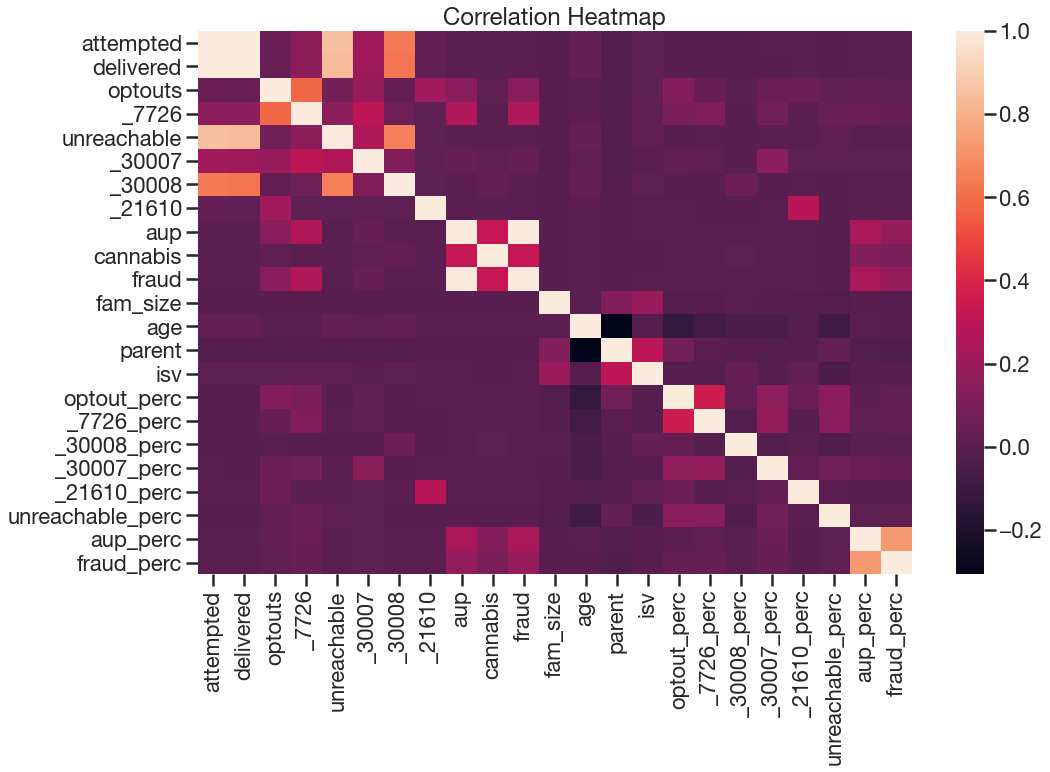

In [ ]:
sns.heatmap(account.corr()).set_title('Correlation Heatmap')

### Load in June Prediction data

In [ ]:
june = pd.read_csv('june_rightshift.csv')
june.head()

,attempted,account_sid,delivered,optouts,_7726,cannabis,unreachable,_30007,_30008,_21610
0,26038,AC9f3116fcac59b5b68a451cba28f5a731,23407.0,1354.0,1.0,0,15,0,2616,0
1,536793,AC06ea2a0e2f80d342b45f46e42571dd02,504624.0,479.0,NaN,0,31670,183,316,0
2,2278,AC9d6d9155f700898c3f4fb05c4e90188b,2240.0,NaN,NaN,0,4,0,27,0
3,22281,ACac15107fc288db00551d7d26bc4cc764,19295.0,132.0,NaN,0,1191,0,266,1475
4,550054,AC55880b122abfcb40df3510b02f02ed9e,521606.0,NaN,NaN,0,27300,1,582,142


In [ ]:
june_aup = pd.read_csv('june_aup.csv')
june_aup.head()

,account_sid,aup
0,AC2eee9d2fafa59aa8751561dee2804fd0,3296
1,ACabcf415da9c2d8399f1f978a33428ff4,3
2,AC9a625c6ca376fcddf89ec76f2f5429a4,12
3,ACf04094ba90d749b2dee6532671a8c807,20
4,ACa639bad1316b5cd355b12b653d6b3437,15


In [ ]:
june_fraud = pd.read_csv('june_fraud.csv')
june_fraud.head()

,account_sid,fraud
0,ACe60b6b50a8891855bd1749249c86ccc9,1
1,AC64853a3869f51d933c1a16739fb730a7,2
2,AC4fca2980b46bbb52ecc5d545d9d921d2,14
3,AC64eb3557cf8f30c4f5e5531cac320dba,145
4,ACa16763d822eb50d89bd1e884d7ec62e8,4


### Merge Datasets

In [ ]:
june = june.merge(june_fraud, on='account_sid', how='left')
june = june.merge(june_aup, on='account_sid', how='left')
june = june.merge(first_twilio, on='account_sid', how='left')
june = june.fillna(0)

In [ ]:
june.head()

,attempted,account_sid,delivered,optouts,_7726,cannabis,unreachable,_30007,_30008,_21610,fraud,aup,friendly_name,default_name
0,26038,AC9f3116fcac59b5b68a451cba28f5a731,23407.0,1354.0,1.0,0,15,0,2616,0,0.0,0.0,connect,0.0
1,536793,AC06ea2a0e2f80d342b45f46e42571dd02,504624.0,479.0,0.0,0,31670,183,316,0,0.0,0.0,frmobile@forrent.com's Account,0.0
2,2278,AC9d6d9155f700898c3f4fb05c4e90188b,2240.0,0.0,0.0,0,4,0,27,0,0.0,0.0,pieter@ubergif.app's Account,0.0
3,22281,ACac15107fc288db00551d7d26bc4cc764,19295.0,132.0,0.0,0,1191,0,266,1475,0.0,0.0,osayame@gmail.com's Account,0.0
4,550054,AC55880b122abfcb40df3510b02f02ed9e,521606.0,0.0,0.0,0,27300,1,582,142,0.0,0.0,brazepuregym,0.0


### Data Preprocessing

In [ ]:
#Generate percentages
june['_7726_perc'] = june['_7726']/june['delivered']
june = june[(june['delivered']>1) & (june['attempted']>1000)]
june['optout_perc'] = june['optouts']/june['delivered']
june['_30008_perc'] = june['_30008']/june['attempted']
june['_30007_perc'] = june['_30007']/june['attempted']
june['_21610_perc'] = june['_21610']/june['attempted']
june['unreachable_perc'] = june['unreachable']/june['attempted']
june['aup_perc'] = june['aup']/june['attempted']
june['fraud_perc'] = june['fraud']/june['attempted']

#Drop accounts with percentages > 1
june=june[june['aup_perc']<=1] #drop 4
june=june[june['fraud_perc']<=1] #drop 1

In [ ]:
june = june.merge(age, on='account_sid', how='inner')
june = june.merge(fam_size, on='account_sid', how='inner')

In [ ]:
june.describe()

,attempted,delivered,optouts,_7726,cannabis,unreachable,_30007,_30008,_21610,fraud,...,_30008_perc,_30007_perc,_21610_perc,unreachable_perc,aup_perc,fraud_perc,age,parent,isv,fam_size
count,8.108500e+04,8.108500e+04,81085.000000,81085.000000,81085.000000,8.108500e+04,8.108500e+04,8.108500e+04,8.108500e+04,8.108500e+04,...,81085.000000,81085.000000,81085.000000,81085.000000,81085.000000,81085.000000,81085.000000,81085.000000,81085.000000,8.108500e+04
mean,8.874638e+04,8.029140e+04,149.307554,0.717580,0.000456,2.602388e+03,6.358994e+02,6.731139e+02,2.743373e+02,3.439068e+01,...,0.007920,0.008972,0.001533,0.038412,0.000352,0.000468,30.178418,0.587125,0.145613,1.021978e+04
std,3.180235e+06,2.936784e+06,2514.148821,16.900543,0.021357,5.750996e+04,1.347037e+04,2.483363e+04,1.969304e+04,5.962818e+03,...,0.038879,0.050051,0.014760,0.070179,0.015274,0.017485,27.380893,0.492354,0.352720,6.760493e+04
min,1.001000e+03,2.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,1.619000e+03,1.531000e+03,0.000000,0.000000,0.000000,1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.004794,0.000000,0.000000,9.000000,0.000000,0.000000,1.000000e+00
50%,3.131000e+03,2.927000e+03,1.000000,0.000000,0.000000,5.600000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000094,0.000000,0.000000,0.016559,0.000000,0.000000,22.000000,1.000000,0.000000,8.900000e+01
75%,9.669000e+03,8.837000e+03,13.000000,0.000000,0.000000,2.510000e+02,2.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,...,0.002009,0.000343,0.000000,0.042222,0.000000,0.000000,46.000000,1.000000,0.000000,7.093000e+03
max,6.392502e+08,6.310780e+08,298105.000000,2929.000000,1.000000,9.159953e+06,2.083357e+06,3.612979e+06,4.701338e+06,1.651080e+06,...,0.999981,0.993409,0.997128,0.999836,0.997159,0.997159,150.000000,1.000000,1.000000,2.063543e+06


## Exploratory Data Analysis

[Text(0.5, 1.0, 'Account Age Distribution')]

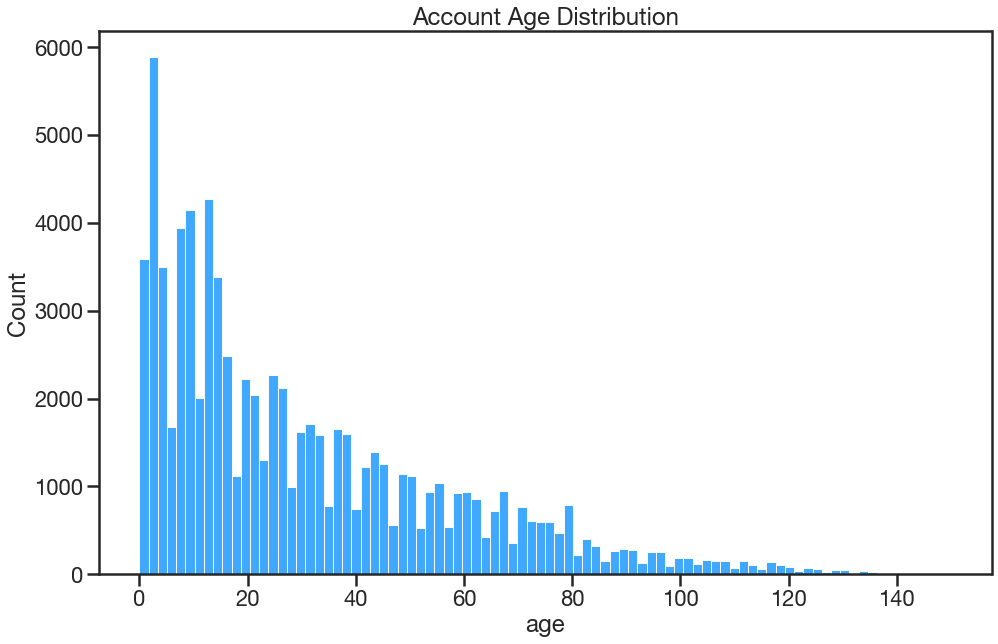

In [ ]:
#Explore account level variables
ax = sns.histplot(data=account,x='age')
ax.set(title = 'Account Age Distribution')

In [ ]:
#Looking into young accounts with small family sizes
account['under_1_yr'] = (account['age']<12)

In [ ]:
account['under_50_fam'] = (account['fam_size']<50)

In [ ]:
account.groupby(['under_1_yr','under_50_fam']).sum()

attempted     delivered    optouts    _7726  \
under_1_yr under_50_fam                                                 
0          0              639047163  5.997130e+08  1685482.0  14987.0   
           1             6330998818  5.990148e+09  6330746.0  42666.0   
1          0              300456091  2.337535e+08  2160607.0  18750.0   
           1              363257826  3.201016e+08  2685126.0  20169.0   

                         unreachable    _30007    _30008    _21610        aup  \
under_1_yr under_50_fam                                                         
0          0                23733204   7437218   3409031   1681374  1708060.0   
           1               192036028  38015078  45379093  28742630  4987055.0   
1          0                11981404   9395576   5322242    893071        0.0   
           1                14314681  11752602   4864590   2704702   106168.0   

                         cannabis  ...   isv  optout_perc  _7726_perc  \
under_1_yr under_50_fam            ...                                  
0          0                  0.0  ...  6406   134.138270    0.593626   
           1                  1.0  ...   828    71.305964    0.561262   
1          0                  0.0  ...  4094   140.328633    1.065071   
           1                  0.0  ...   195    85.857137    1.010995   

                         _30008_perc  _30007_perc  _21610_perc  \
under_1_yr under_50_fam                                          
0          0              110.169822   169.265981    22.996622   
           1              285.887353   230.076930    56.383929   
1          0              226.461420   177.588622    32.502418   
           1              108.586695   176.370381    13.095787   

                         unreachable_perc   aup_perc  fraud_perc  over_1_yr  
under_1_yr under_50_fam                                                      
0          0                   880.137177   1.047264    1.047264      24707  
           1                   974.344441  22.029193   24.065501      28648  
1          0                   747.947560   0.000000    1.457711          0  
           1                   477.365326   7.995927   26.162665          0  

[4 rows x 24 columns]

In [ ]:
account.groupby(['under_1_yr','under_50_fam']).count()

attempted  account_sid  delivered  optouts  _7726  \
under_1_yr under_50_fam                                                      
0          0                 25909        25909      25909    25909  25909   
           1                 29456        29456      29456    29456  29456   
1          0                 15488        15488      15488    15488  15488   
           1                  9263         9263       9263     9263   9263   

                         unreachable  _30007  _30008  _21610    aup  ...  \
under_1_yr under_50_fam                                              ...   
0          0                   25909   25909   25909   25909  25909  ...   
           1                   29456   29456   29456   29456  29456  ...   
1          0                   15488   15488   15488   15488  15488  ...   
           1                    9263    9263    9263    9263   9263  ...   

                           isv  optout_perc  _7726_perc  _30008_perc  \
under_1_yr under_50_fam                                                
0          0             25909        25909       25909        25909   
           1             29456        29456       29456        29456   
1          0             15488        15488       15488        15488   
           1              9263         9263        9263         9263   

                         _30007_perc  _21610_perc  unreachable_perc  aup_perc  \
under_1_yr under_50_fam                                                         
0          0                   25909        25909             25909     25909   
           1                   29456        29456             29456     29456   
1          0                   15488        15488             15488     15488   
           1                    9263         9263              9263      9263   

                         fraud_perc  over_1_yr  
under_1_yr under_50_fam                         
0          0                  25909      25909  
           1                  29456      29456  
1          0                  15488      15488  
           1                   9263       9263  

[4 rows x 25 columns]

In [ ]:
account.sum()

attempted                                                  7633759898
account_sid         AC0c4da9c0a8c20ea8890c2ca186768bedACbdccf1d7b8...
delivered                                                7143716573.0
optouts                                                    12861961.0
_7726                                                         96572.0
unreachable                                                 242065317
_30007                                                       66600474
_30008                                                       58974956
_21610                                                       34021777
aup                                                         6801283.0
cannabis                                                          1.0
fraud                                                       6895516.0
fam_size                                                    801018216
age                                                           2446401
parent              

(0.0, 0.5)

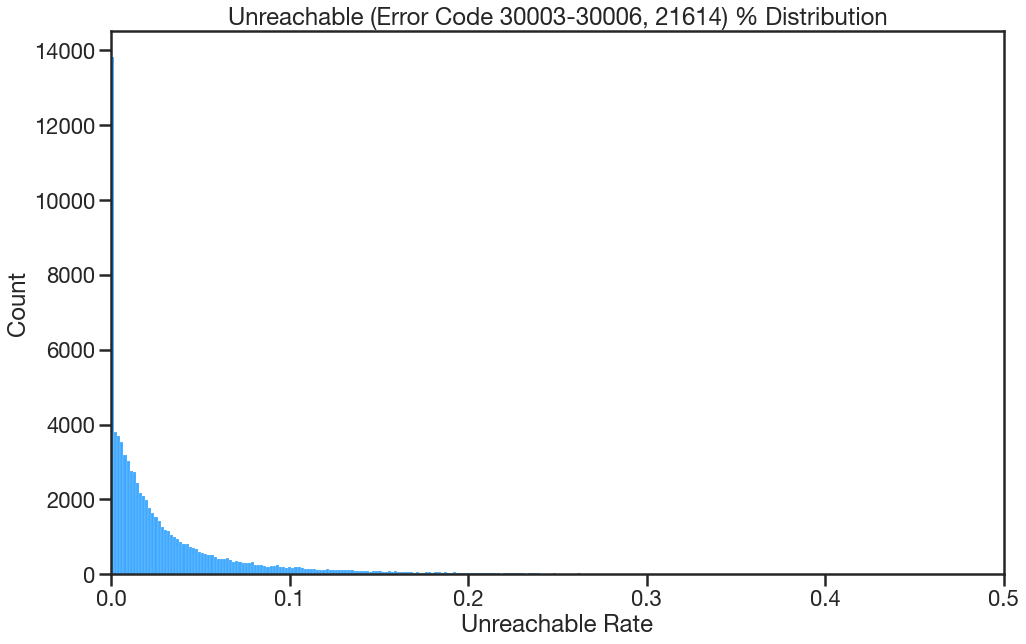

In [ ]:
ax = sns.histplot(data=account,x='unreachable_perc')
ax.set(title = 'Unreachable (Error Code 30003-30006, 21614) % Distribution')
ax.set(xlabel='Unreachable Rate')
ax.set_xlim(0, 0.5)

In [ ]:
#sanity check
account['_30007_perc'].describe()

count    80116.000000
mean         0.009403
std          0.050605
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000311
max          0.999235
Name: _30007_perc, dtype: float64

In [ ]:
account['_30008_perc'].describe()

count    80116.000000
mean         0.009126
std          0.045682
min          0.000000
25%          0.000000
50%          0.000216
75%          0.002187
max          0.999992
Name: _30008_perc, dtype: float64

In [ ]:
account['_21610_perc'].describe()

count    80116.000000
mean         0.001560
std          0.014239
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.998900
Name: _21610_perc, dtype: float64

In [ ]:
account['_21610_perc'].sort_values()

221047    0.000000
286279    0.000000
286276    0.000000
286272    0.000000
286271    0.000000
            ...   
392214    0.639683
133080    0.669820
49378     0.969962
52500     0.997421
211066    0.998900
Name: _21610_perc, Length: 80116, dtype: float64

(0.0, 0.1)

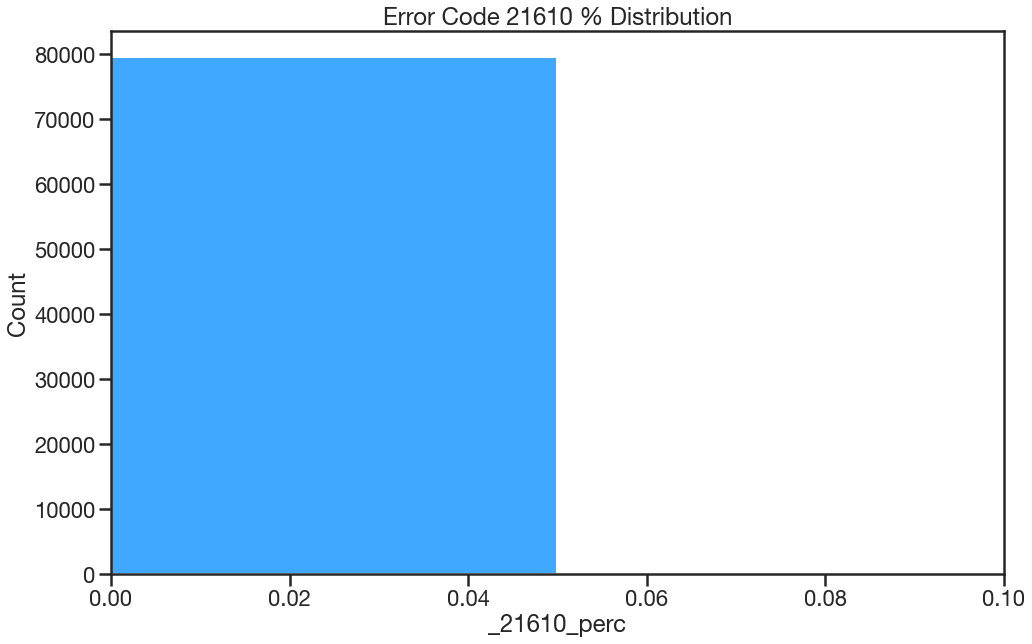

In [ ]:
#21610 Distribution
ax = sns.histplot(data=account,x='_21610_perc', bins=20)
ax.set(title = 'Error Code 21610 % Distribution')
ax.set_xlim(0, 0.1)

[Text(0, 0, 'Has'), Text(1, 0, 'Not Have')]

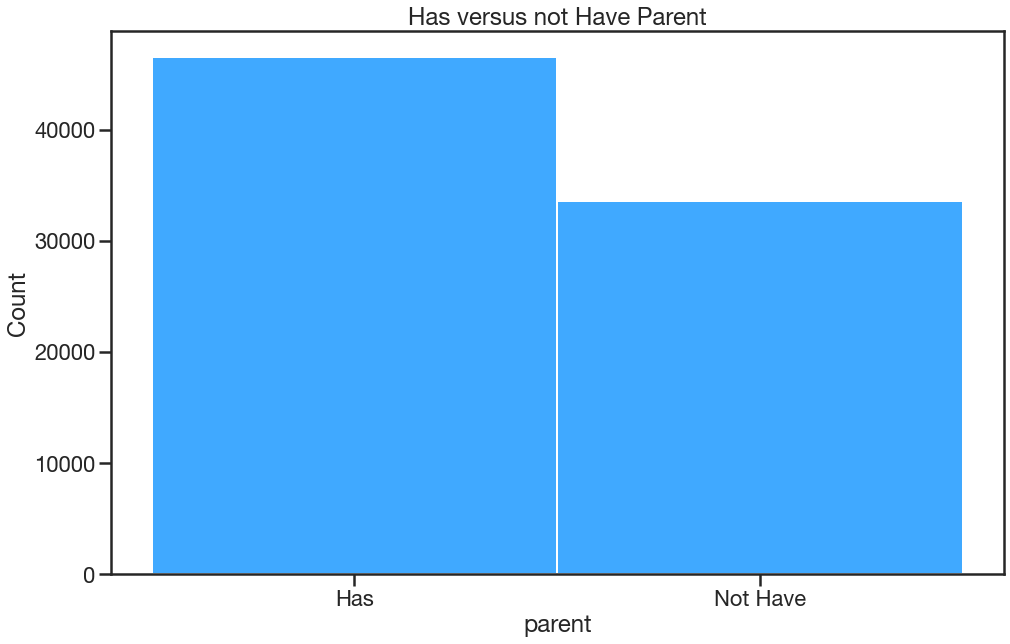

In [ ]:
#Count of have or not have a parent
account['parent'] = account['parent'].astype(str)
ax = sns.histplot(data=account,x='parent')
ax.set(title = 'Has versus not Have Parent')
ax.set_xticklabels(['Has','Not Have'])

[Text(0, 0, 'Is'), Text(1, 0, 'Is Not')]

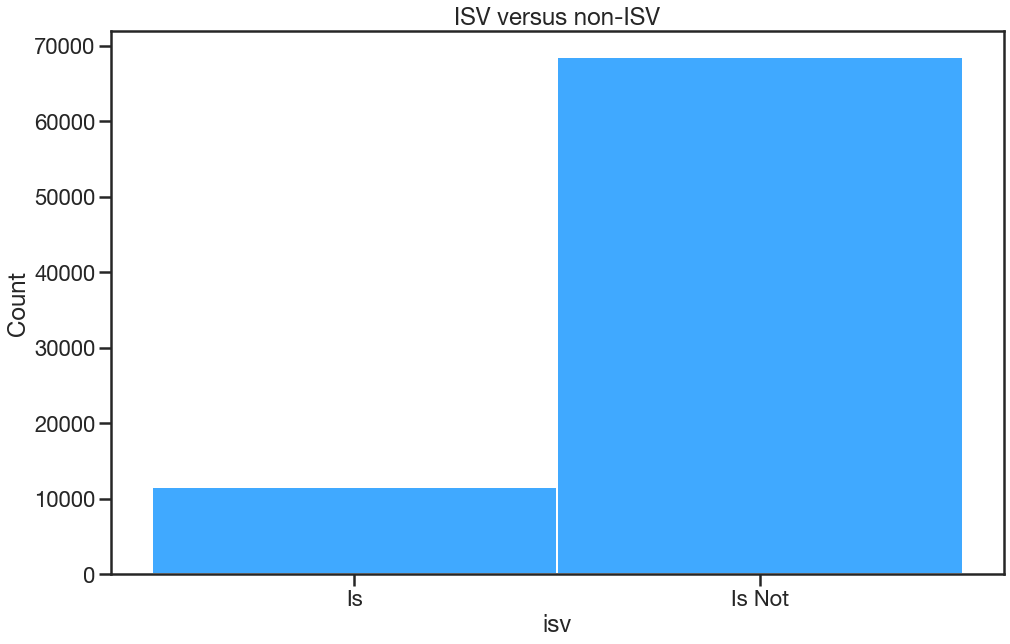

In [ ]:
#count of ISV v.s. non-ISV
account['isv'] = account['isv'].astype(str)
ax = sns.histplot(data=account,x='isv')
ax.set(title = 'ISV versus non-ISV')
ax.set_xticklabels(['Is','Is Not'])

[Text(0, 0, 'Is'), Text(1, 0, 'Is Not')]

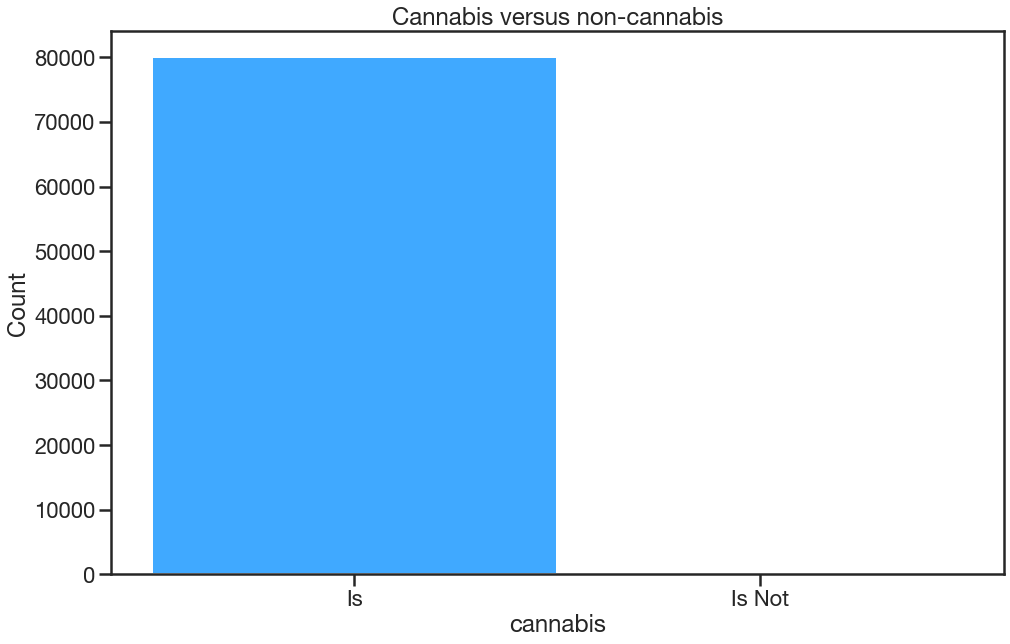

In [ ]:
#Count of cannabis v.s. non-cannabis
account['cannabis'] = account['cannabis'].astype(str)
ax = sns.histplot(data=account,x='cannabis')
ax.set(title = 'Cannabis versus non-cannabis')
ax.set_xticklabels(['Is','Is Not'])

In [ ]:
pd.pivot_table(account, values=['_7726_perc','optout_perc'], index=['isv'])

,_7726_perc,optout_perc
isv,,
0,0.000042,0.005480
1,0.000031,0.004836


In [ ]:
pd.pivot_table(account, values=['_7726_perc','optout_perc'], index=['parent'])

,_7726_perc,optout_perc
parent,,
0,0.000037,0.003962
1,0.000043,0.006414


In [ ]:
pd.pivot_table(account, values=['_7726_perc','optout_perc'], index=['cannabis'])

,_7726_perc,optout_perc
cannabis,,
0.0,0.000040,0.005388
1.0,0.000016,0.009498


### Export Data

In [ ]:
account.to_csv('feature_engineered_May.csv',index=False)
june.to_csv('feature_engineered_June.csv',index=False)